# What is torch.nn really?

PyTorch provides the elegantly designed modules and classes <b>torch.nn</b>, <b>torch.optim</b>, <b>Dataset</b>, and <b>DataLoader</b> to help you create and train neural networks. In order to fully utilize their power and customize them for your problem, you need to really understand exactly what they’re doing. To develop this understanding, we will first train basic neural net on the MNIST data set without using any features from these models; we will initially only use the most basic PyTorch tensor functionality. Then, we will incrementally add one feature from <b>torch.nn</b>, <b>torch.optim</b>, <b>Dataset</b>, and <b>DataLoader</b> at a time, showing exactly what each piece does, and how it works to make the code either more concise, or more flexible.

## MNIST data setup

We will use <b>pathlib</b> for dealing with paths (part of the Python 3 standard library), and will download the dataset using <b>requests</b>. We will only import modules when we use them, so you can see exactly what’s being used at each point.

In [1]:
from pathlib import Path
import requests

In [2]:
DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)

In [3]:
URL = 'http://deeplearning.net/data/mnist/'
FILENAME = 'mnist.pkl.gz'

In [5]:
if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open('wb').write(content)

This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data.

In [6]:
import pickle
import gzip

In [7]:
with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; we need to reshape it to 2d first.

In [8]:
import matplotlib.pyplot as plt
import numpy as np

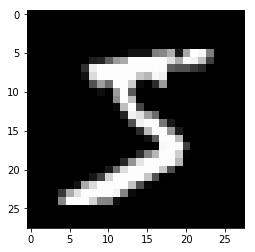

In [11]:
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.show()

In [15]:
import torch

In [16]:
x_train, y_train, x_valid, y_valid = map(torch.tensor,
                  (x_train, y_train, x_valid, y_valid))

In [19]:
n, c = x_train.shape

In [21]:
x_train, x_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9))

## Neural net from scratch (no torch.nn)

We are initializing the weights here with Xavier initialisation (by multiplying with 1/sqrt(n)).

In [22]:
import math

In [23]:
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [24]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

In [25]:
def model(xb):
    return log_softmax(xb @ weights + bias)

In the above, the <b>@</b> stands for the dot product operation. We will call our function on one batch of data (in this case, 64 images). This is one forward pass. Note that our predictions won’t be any better than random at this stage, since we start with random weights.

In [26]:
bs = 64 # batch size

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb) # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.3551, -2.6207, -1.8830, -2.1669, -2.3487, -2.4743, -2.6120, -2.1771,
        -2.4766, -2.1612], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the <b>preds</b> tensor contains not only the tensor values, but also a gradient function. We’ll use this later to do backprop.

Let’s implement negative log-likelihood to use as the loss function (again, we can just use standard Python):

In [27]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_fn = nll

Let’s check our loss with our random model, so we can see if we improve after a backprop pass later.

In [28]:
yb = y_train[0:bs]
print(loss_fn(preds, yb))

tensor(2.3119, grad_fn=<NegBackward>)


Let’s also implement a function to calculate the accuracy of our model. For each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [29]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

Let’s check the accuracy of our random model, so we can see if our accuracy improves as our loss improves.

In [30]:
accuracy(preds, yb)

tensor(0.0625)

We can now run a training loop. For each iteration, we will:
- select a mini-batch of data (of size <b>bs</b>).
- use the model to make predictions.
- calculate the loss
- <b>loss.backward()</b> updates the gradients of the model, in this case, weights and bias.

We now use these gradients to update the weights and bias. We do this within the torch.no_grad() context manager, because we do not want these actions to be recorded for our next calculation of the gradient. 

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e., <b>loss.backward()</b> adds the gradients to whatever is already stored, rather than replacing them).

In [31]:
from IPython.core.debugger import set_trace

In [32]:
lr = 0.5
epochs = 2

In [34]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i : end_i]
        yb = y_train[start_i : end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

That’s it: we’ve created and trained a minimal neural network (in this case, a logistic regression, since we have no hidden layers) entirely from scratch!

Let’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have decreased and accuracy to have increased, and they have.

In [37]:
loss_fn(model(xb), yb).item(), accuracy(model(xb), yb).item()

(0.07997673749923706, 1.0)